# Advanced Lane Detection

## Goal
The goal of this project is to detect lines and mark the lane area. 

## Method 
#### Overview 
The method for lane detection includes the following steps[1]:
- Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
- Apply a distortion correction to raw images.
- Use color transforms, gradients, etc., to create a thresholded binary image.
- Apply a perspective transform to rectify binary image ("birds-eye view").
- Detect lane pixels and fit to find the lane boundary.
- Determine the curvature of the lane and vehicle position with respect to center.
- Warp the detected lane boundaries back onto the original image.
- Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

#### Camera Calibration 
To accurately detect the lane area, camera calibration is required to correct the distortion from the camera lense. In order to obtain the correction matrix, chess board images taken by the camera are used. 

In [209]:
#import libraries 
import numpy as np 
import cv2 
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
import glob 

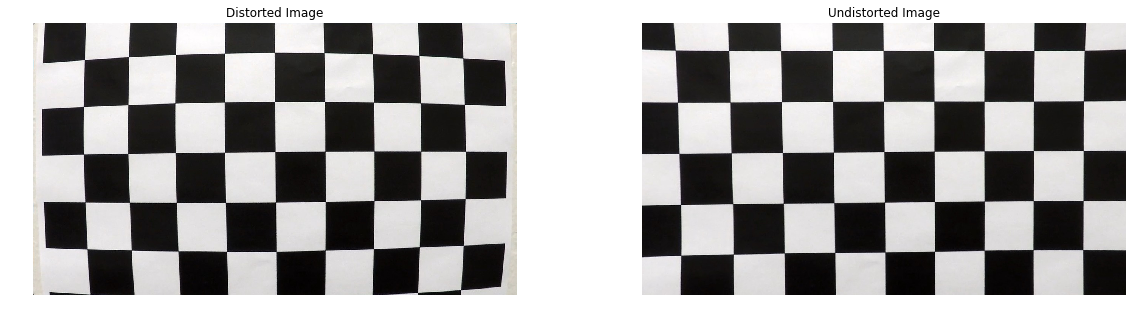

In [283]:
CAM_IMGS = glob.glob('./camera_cal/calibration*.jpg')
SAMPLE_IMG = mpimg.imread('./test_images/straight_lines1.jpg') 
IMG_SHAPE = SAMPLE_IMG.T.shape[1:3] # all images have the same shape 

CORNER_X = 9
CORNER_Y = 6
ACTUAL_POS = np.zeros((CORNER_X * CORNER_Y, 3), np.float32)
ACTUAL_POS[:,:2] = np.mgrid[0:CORNER_X, 0:CORNER_Y].T.reshape(-1,2) # fill positon idx 

obj_points = []
img_points = []

for each_img in CAM_IMGS:
    img = mpimg.imread(each_img)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    [ret, corners] = cv2.findChessboardCorners(gray, (CORNER_X,CORNER_Y), None)    
    if ret: # when corners are detected 
        img_points.append(corners)
        obj_points.append(ACTUAL_POS)

# use all detected corners to generate retval, cameraMatrix, distCoeffs, rvecs, tvecs      
RET, MTX, DIST, RVECS, TVECS =  cv2.calibrateCamera(obj_points, img_points,
                                                        IMG_SHAPE, None, None)


# sample correted imgs 
plt.figure(figsize=(20,5))
sample_cam = mpimg.imread(CAM_IMGS[0])
plt.subplot(1,2,1)
plt.title("Distorted Image")
plt.axis('off')
plt.imshow(sample_cam)
uncam_chess = cv2.undistort(sample_cam, MTX, DIST, None, MTX) # undistort cam
plt.subplot(1,2,2)
plt.title("Undistorted Image")
plt.imshow(uncam_chess)
plt.axis('off')
plt.show()

#### Perspective Transform 
To create the perspective transformation matrix, four corners of the target area in a straight lane situation are recorded. From a bird's eye view, the trapezoidal shape area in the image should actually be a rectangle and the original coordinates. As the most important area to detect is in front of the vehicle, two bottom points of the interest area are chosen at the front of the vehicle, the other two points are chosen with same y coordinates.
With the way four vertices of the area are selected, the actual coordiantes from bird eye view will have the following relationship:

PIC_POS = [[top_x1,top_y1], BOTTOM_RIGHT, BOTTOM_LEFT, [top_x2,top_y1]])

DES_POS = [[BOTTOM_RIGHT[0], PIC_POS[0][1]], BOTTOM_RIGHT,
                      BOTTOM_LEFT, [BOTTOM_LEFT[0],PIC_POS[-1][1]]])

which can be shown by this image for straight lane:
<img src = "https://github.com/vacous/Udacity-SelfDriving/blob/master/Project04-AdvancedLane/file_images/view.PNG?raw=true" width = "500"/>

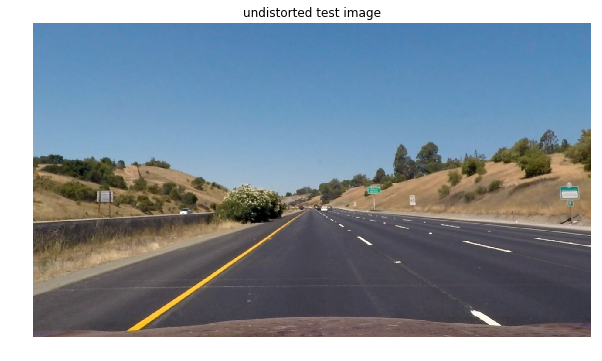

In [284]:
BOTTOM_LEFT =  [256,682]
BOTTOM_RIGHT = [1040,682]
uncam_sample = cv2.undistort(SAMPLE_IMG, MTX, DIST, None, MTX)
# manually picked points
plt.figure(figsize=(10, 12))
plt.title("undistorted test image")
plt.imshow(uncam_sample)
plt.axis("off")
plt.show()


PIC_POS = np.float32([[804,527], BOTTOM_RIGHT, BOTTOM_LEFT, [479,527]])
DES_POS = np.float32([[BOTTOM_RIGHT[0], PIC_POS[0][1]], BOTTOM_RIGHT,
                      BOTTOM_LEFT, [BOTTOM_LEFT[0],PIC_POS[-1][1]]])
PERSP_M = cv2.getPerspectiveTransform(PIC_POS, DES_POS)
INVER_M = cv2.getPerspectiveTransform(DES_POS, PIC_POS)

With the above selection of points, the perpsective image display the lane area as a rectangle.

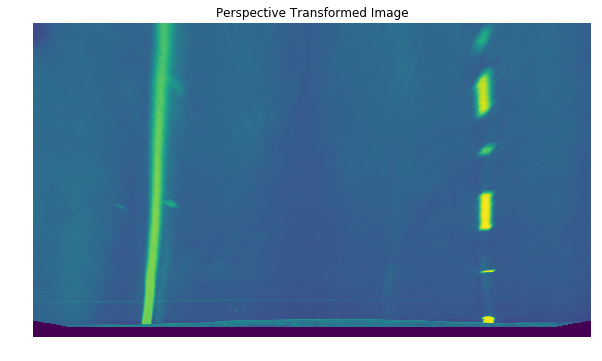

In [285]:
gray_uncam_sample = cv2.cvtColor(uncam_sample, cv2.COLOR_RGB2GRAY)
check_img = cv2.warpPerspective(gray_uncam_sample, PERSP_M, IMG_SHAPE, flags = cv2. INTER_LINEAR)
plt.figure(figsize=(10,15))
plt.title("Perspective Transformed Image")
plt.imshow(check_img)
plt.axis("off")
plt.show()

#### preprocess images 
To make lane detection more accurate, two approaches are used to detect the lane. The first one is sobel operator and the second one is HLS color channel. H channel and S channel along with y direction sobel are used. By combining the result from all 3 filtering approaches, a confident bird-eye view image of the lane can be obtained.

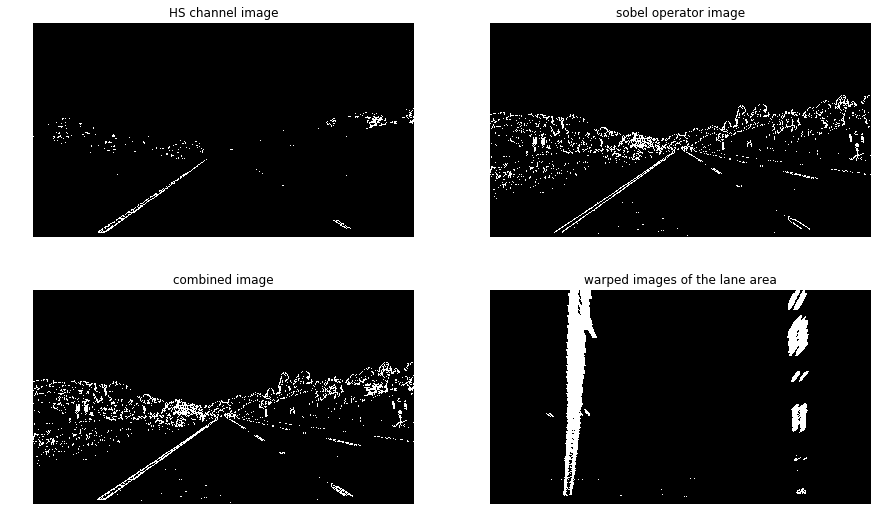

In [286]:
def processAndUnwarp(in_uncam, in_MTX, in_DIST, in_PERSP_M, if_plot = False):
    '''
    takes an img correct with camera matrix and perspective matrix 
    '''
    gray_img = cv2.cvtColor(in_uncam, cv2.COLOR_RGB2GRAY)
    hls_img = cv2.cvtColor(in_uncam, cv2.COLOR_RGB2HLS)
    

    
    # apply s channel 
    s_img = hls_img[:,:,2]
    s_thresh_min = 130
    s_thresh_max = 250
    s_binary = np.zeros_like(s_img)
    s_binary[(s_img >= s_thresh_min) & (s_img <= s_thresh_max)] = 1
#     plt.figure()
#     plt.imshow(s_binary)
#     plt.show()
    
    
    # apply h channel
    l_img = hls_img[:,:,0]
    l_thresh_min = 50
    l_thresh_max = 300
    l_binary = np.zeros_like(l_img)
    l_binary[(l_img >= l_thresh_min) & (l_img <= l_thresh_max)] = 1
#     plt.figure()
#     plt.imshow(l_binary)
#     plt.show()
    
    ls_binary = np.zeros_like(l_binary)
    ls_binary[(l_binary == 0) & (s_binary == 1)] = 1
     
    # apply sobel operator 
    sobel_x = cv2.Sobel(gray_img, cv2.CV_64F, 1, 0)     
    abs_sobel = np.absolute(sobel_x)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    thresh_min = 20
    thresh_max = 1000
    sx_binary = np.zeros_like(scaled_sobel)
    sx_binary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    
    # combine two img 
    combined_binary = np.zeros_like(sx_binary)
    combined_binary[(ls_binary == 1) | (sx_binary == 1)] = 1 

    img_shape = in_uncam.T.shape[1:3]
    warped = cv2.warpPerspective(combined_binary, in_PERSP_M, img_shape, flags = cv2. INTER_LINEAR)
    if if_plot:
        plt.figure(figsize=(15,9))
        plt.subplot(2,2,1)
        plt.axis("off")
        plt.title("HS channel image")
        plt.imshow(ls_binary, cmap='gray')
        plt.subplot(2,2,2)
        plt.axis("off")
        plt.title("sobel operator image")
        plt.imshow(sx_binary, cmap='gray')
        plt.subplot(2,2,3)
        plt.axis("off")
        plt.title("combined image")
        plt.imshow(combined_binary, cmap='gray')
        plt.subplot(2,2,4)
        plt.axis("off")
        plt.title("warped images of the lane area")
        plt.imshow(warped, cmap='gray')
        plt.show()
    return warped
sample_warp_result = processAndUnwarp(uncam_sample, MTX, DIST, PERSP_M, if_plot = True)


#### Find the lane with window search
To find the pixle position, window search is used to find the pixle with value 1 inside the window. The position of the window is updated each time using the position of the previous window. The initial position of the window is decided using the peak of the sum of pixle for each x coordinate. 
Since there are many cases that there is not enough points on one side to produce a fitted line with high confidence, the fit line on the side with more data points will be used, if there is a high discrepency between the curvature of two sides. 

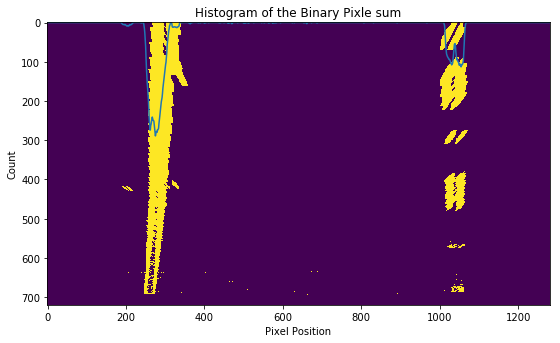

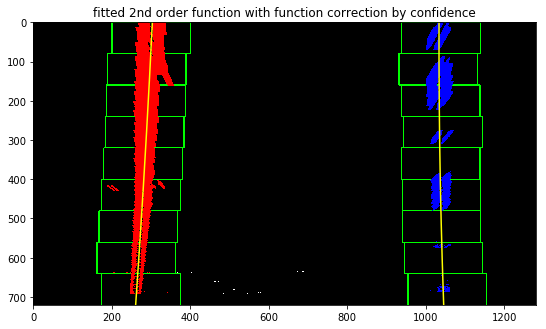

In [287]:
def windowFitInitial(in_grad_img, ym_per_pix, xm_per_pix, if_plot = False):
    '''
    takes a gradient img 
    returns two fit lines of the curve coefficeints 
    this function is from udaccity 
    '''
    binary_warped = in_grad_img
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 150
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # find the real world fit line and curvature 
    # convert to real world unit
    left_fit_cr = np.polyfit(lefty * ym_per_pix, leftx * xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty * ym_per_pix, rightx * xm_per_pix, 2)
    y_eval = max(np.max(lefty), np.max(righty))
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
   


    # use the max curvauture of the two and correct the fit function that has lower curvature
    # the confidence of the fit result is approximated by the ratio of data points 
    # if two curvature has a very large difference 
    out_curvature = min(left_curverad, right_curverad)
    if out_curvature/max(left_curverad, right_curverad) < 0.25:
        if left_curverad < right_curverad:
            right_fit[2] = right_fit[0] * y_eval**2 + right_fit[1] * y_eval + right_fit[2] - (left_fit[0] * y_eval**2 + left_fit[1] * y_eval)
            # make sure the value is the same at the bottom after switching the coefficients 
            right_fit[0] = left_fit[0]
            right_fit[1] = left_fit[1]
        else:
            left_fit[2] = left_fit[0] * y_eval**2 + left_fit[1] * y_eval + left_fit[2] - (right_fit[0] * y_eval**2 + right_fit[1] * y_eval)
            left_fit[0] = right_fit[0]
            left_fit[1] = right_fit[1]
            # calculate the difference between (center of the two fitted lines) and the (center of the image) as the offset
    lane_mid = (left_fit[0] * y_eval**2 + left_fit[1] * y_eval + left_fit[2]) + (right_fit[0] * y_eval**2 + right_fit[1] * y_eval + right_fit[2])/2
    actual_mid = in_grad_img.shape[1]/2
    out_offset = (actual_mid - lane_mid) * xm_per_pix
    
    if if_plot:
        # hist of the pixle sum        
        plt.figure(figsize=(9,15))
        plt.title("Histogram of the Binary Pixle sum")
        plt.xlabel("Pixel Position")
        plt.ylabel("Count")
        plt.imshow(in_grad_img)
        plt.plot(histogram)

        # window and the fitted lines 
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        plt.figure(figsize=(9,15))
        plt.title("fitted 2nd order function with function correction by confidence")
        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        plt.show()
        
    return left_fit, right_fit, out_curvature, out_offset  

sampe_left, sample_right, sample_curvature, sample_offset = windowFitInitial(sample_warp_result, 30/720, 3.7/700/4, if_plot= True)
# xm_per_pix can be approximated using the car width with 3.7/700/4, the car width in the image is approximately 1.7m 
# which is reasonable for common cars 

#### Combine original image with marked lane area

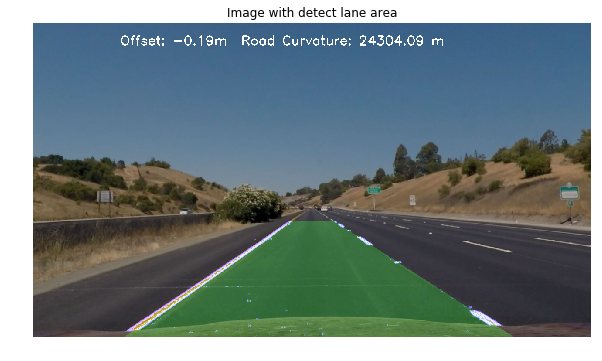

In [288]:
def combineLaneArea(ori_img, warped, left_fit, right_fit, max_y, Minv, in_curvature, in_offset, if_plot = False):
    '''
    taken from the udacity tips 
    '''
    ploty = np.array(range(max_y*100))*0.01
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (ori_img.shape[1], ori_img.shape[0])) 
    warp_add = np.dstack((warped * 51, warped * 51, warped * 255))
    lane_img = cv2.warpPerspective(warp_add, Minv, (ori_img.shape[1], ori_img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(ori_img, 1, newwarp, 0.3, 0)
    result = cv2.addWeighted(result, 0.75, lane_img, 1, 0)
    curvature_string = "Offset: " + ("%.2f" % in_offset) + "m  " + "Road Curvature: " + ("%.2f" % in_curvature) + " m"
    result = cv2.putText(result, curvature_string, (200, 50) , cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2)
    if if_plot:
        plt.figure(figsize=(10,10))
        plt.axis("off")
        plt.imshow(result)
        plt.title("Image with detect lane area")
        plt.show()
    return result 
    
sample_result = combineLaneArea(uncam_sample, sample_warp_result, sampe_left, sample_right,
                                IMG_SHAPE[1], INVER_M, sample_curvature, sample_offset,
                                if_plot = True)

#### Pipe Line 

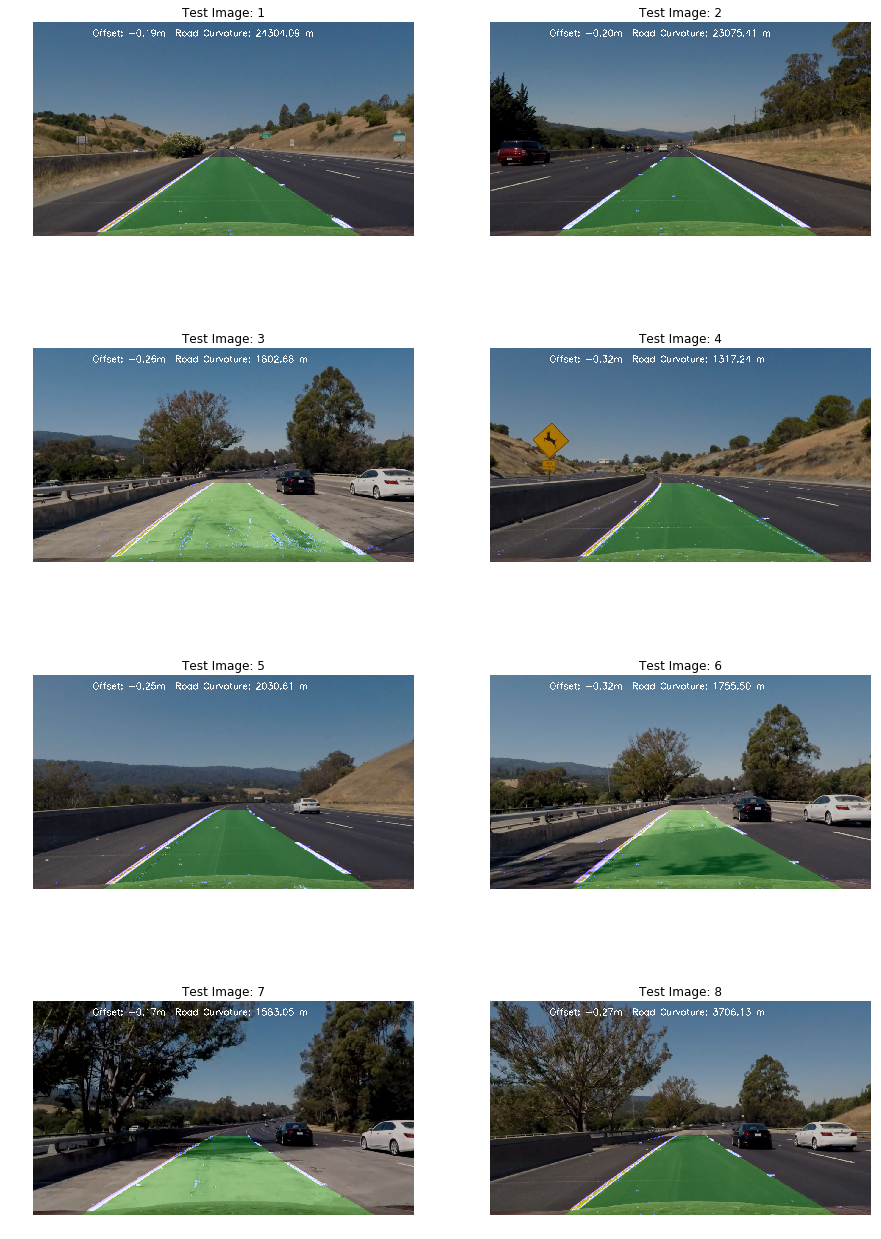

In [289]:
def findLane(in_img, in_MTX = MTX, in_DIST = DIST
             , in_PERSP_M = PERSP_M, in_INVERSE_M = INVER_M
             , ym_per_pix = 30/720, xm_per_pix = 3.7/700/4):
    global IMG_SHAPE
    # undistort the image first
    uncam_img = cv2.undistort(in_img, in_MTX, in_DIST, None, in_MTX)
    # preprocess image to give binary warped image 
    warp_result = processAndUnwarp(uncam_img, in_MTX, in_DIST, in_PERSP_M)
    # fit the 2nd order function 
    fit_left, fit_right, out_curvature, out_offset = windowFitInitial(warp_result, 30/720, 3.7/700/4)
    # combine the image together
    combine_result = combineLaneArea(uncam_img, warp_result, fit_left, fit_right, IMG_SHAPE[1],
                                     INVER_M, out_curvature, out_offset, if_plot=False)
    return combine_result

test_fig = findLane(mpimg.imread('./test_images/test1.jpg'), MTX, DIST, PERSP_M, INVER_M, 30/720, 3.7/700/4)
ALL_TEST_IMGS = glob.glob('./test_images/straight_lines*.jpg')
ALL_TEST_IMGS.extend(glob.glob('./test_images/test*.jpg'))
plt.figure(figsize=(15,23))
for idx in range(len(ALL_TEST_IMGS)):
    each_img = ALL_TEST_IMGS[idx]
    temp_img = mpimg.imread(each_img)
    output_img = findLane(temp_img, MTX, DIST, PERSP_M, INVER_M, 30/720, 3.7/700/4)
    plt.subplot(4,2,idx+1)
    plt.axis("off")
    plt.title("Test Image: " + str(idx+1))
    plt.imshow(output_img)
plt.show()
    

## Result 

In [281]:
from moviepy.editor import VideoFileClip
# video 01
white_output = '1.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(findLane)
white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video 1.mp4
[MoviePy] Writing video 1.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [02:15<00:00,  9.19it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: 1.mp4 



From the [viedo](https://youtu.be/iU9sOColgDI) it can be seen that the pipline and approaches handles the lane detection task well if there is a good contrast between the road and the lane side lines. However, when shadows appears, or when the contrast decreases, the detection will become less stable. Particularly, the estimate of both offset and road curvature could be very inaccurate.
To improve the robustness of the pipeline, more tuning on the image preprocessing parameters could be helpful. In addition, combining the inference from a short distance and long distance of the vehicle might also improve the detection, since, in most of the cases, lane detection for short distance ahead of the vehicle is very accurate. 